In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn import linear_model
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
jordan = pd.read_csv("jordan_career.csv")
lebron = pd.read_csv("lebron_career.csv")

###
pd.set_option('display.max_rows', jordan.shape[0] + 1)
pd.set_option('display.max_rows', lebron.shape[0] + 1)
pd.set_option('display.max_columns', jordan.shape[1] + 1)
pd.set_option('display.max_columns', lebron.shape[1] + 1)
###

jordan.drop(["game", "date", "team", "opp", "minus_plus"], axis=1, inplace=True) 
lebron.drop(["game", "date", "team", "opp", "minus_plus"], axis=1, inplace=True) 

jordan["threep"] = jordan["threep"].fillna(0)
lebron["threep"] = lebron["threep"].fillna(0)

jordan["ftp"] = jordan["ftp"].fillna(0)
lebron["ftp"] = lebron["ftp"].fillna(0)

jordan["result"] = [int(res.split(" ")[1][1:-1]) for res in jordan["result"]]
lebron["result"] = [int(res.split(" ")[1][1:-1]) for res in lebron["result"]]

t_age = lambda a, b: a + b / 365
jordan["age"] = [t_age(*[int(i) for i in age.split("-")]) for age in jordan["age"]]
lebron["age"] = [t_age(*[int(i) for i in age.split("-")]) for age in lebron["age"]]

t_time = lambda a, b: a + b / 60
jordan["mp"] = [t_time(*[int(i) for i in m.split(":")]) for m in jordan["mp"]]
lebron["mp"] = [t_time(*[int(i) for i in m.split(":")]) for m in lebron["mp"]]

In [3]:
def split_df(x, s1=0.6, s2=0.8):
    size = x.shape[0]
    return x[int(size * s1):], x[int(size * s1):int(size * s2)], x[:int(size * s2)]


def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    return (x_train - mean[None, :]) / std[None, :]

In [4]:
X_jordan = jordan[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_jordan = jordan["game_score"]
X_lebron = lebron[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_lebron = lebron["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

X_train_l, X_test_l, X_cross_l = split_df(X_lebron)
y_train_l, y_test_l, y_cross_l = split_df(y_lebron)


Coefs (per dim)  [ 0.00464374 -0.00328273 -0.00940925  0.30248009 -0.69868202  0.04646952
  0.07968736 -0.04312301 -0.06229749  0.35970956 -0.40964839 -0.03023663
  0.39693622 -0.04795447  0.34898175  0.66496453  1.00324258  0.63337203
 -1.04282229  1.04435709]  and intercept:  -0.29978830416428437

Training Score: 0.9971771029353605
Testing Score: 0.9967125604981225

Training MSE:  0.2221873312982712
Testing MSE:  0.2156744461815671

Testing R2 score:  0.9967125604981225


Text(0, 0.5, 'Predicted game_score')

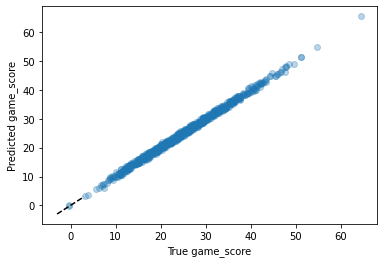

In [5]:
regr_jordan = linear_model.LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

print('\nCoefs (per dim) ', regr_jordan.coef_, ' and intercept: ', regr_jordan.intercept_)
print('\nTraining Score:', regr_jordan.score(X_train_j, y_train_j) )
print('Testing Score:', regr_jordan.score(X_test_j, y_test_j) )
print('\nTraining MSE: ', np.mean((regr_jordan.predict(X_train_j) - y_train_j)**2))
print('Testing MSE: ', np.mean((regr_jordan.predict(X_test_j) - y_test_j)**2))
print('\nTesting R2 score: ', r2_score(y_test_j, regr_jordan.predict(X_test_j)))

# Visualization of target and predicted responses
clf = linear_model.LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)
plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

### regresion with just the important/relevant attributes 


Coefs (per dim)  [ 1.26077459e-01 -4.45134047e-01 -4.31655823e-03  4.37455464e-04
  1.51040083e-01 -1.99527612e-01 -1.07474804e-03  6.62758797e-02
  9.46286742e-02  1.89016325e-01  1.73765218e-01  6.79076615e-02
 -1.90806423e-01  1.07619461e+00]  and intercept:  0.009074958194991989

Training Score: 0.9971087212443945
Testing Score: 0.996656757202231

Training MSE:  0.0025283979489000717
Testing MSE:  0.002436913161587707

Testing R2 score:  0.996656757202231


Text(0, 0.5, 'Predicted game_score')

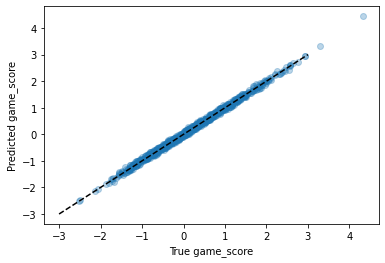

In [6]:
js = standarize(jordan)

X_jordan = js[["fg", "fga", "fgp", "threep", "ft", "fta", "ftp", "orb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_jordan = js["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

regr_jordan = linear_model.LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

print('\nCoefs (per dim) ', regr_jordan.coef_, ' and intercept: ', regr_jordan.intercept_)
print('\nTraining Score:', regr_jordan.score(X_train_j, y_train_j) )
print('Testing Score:', regr_jordan.score(X_test_j, y_test_j) )
print('\nTraining MSE: ', np.mean((regr_jordan.predict(X_train_j) - y_train_j)**2))
print('Testing MSE: ', np.mean((regr_jordan.predict(X_test_j) - y_test_j)**2))
print('\nTesting R2 score: ', r2_score(y_test_j, regr_jordan.predict(X_test_j)))

# Visualization of target and predicted responses
clf = linear_model.LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)
plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')


Coefs (per dim)  [ 1.078115    0.1178023  -0.44043259  0.14777872 -0.19755116  0.11146924
  0.08041658  0.1736452   0.06781741 -0.19075937  0.18909332]  and intercept:  0.00907986845568548

Training Score: 0.9971052831388775
Testing Score: 0.9966659229629657

Training MSE:  0.0025314045420625005
Testing MSE:  0.002430232174198686

Testing R2 score:  0.9966659229629657


Text(0, 0.5, 'Predicted game_score')

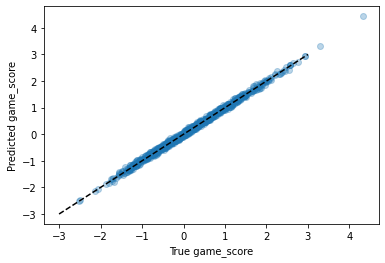

In [7]:
#X_jordan = js[["age", "result", "mp", "fgp", "three", "threeatt", "threep", "ftp", "trb"]]
X_jordan = js[["pts", "fg", "fga", "ft", "fta", "orb", "drb", "stl", "blk", "tov", "ast"]]
y_jordan = js["game_score"]

X_train_j, X_test_j, X_cross_j = split_df(X_jordan)
y_train_j, y_test_j, y_cross_j = split_df(y_jordan)

regr_jordan = linear_model.LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

print('\nCoefs (per dim) ', regr_jordan.coef_, ' and intercept: ', regr_jordan.intercept_)
print('\nTraining Score:', regr_jordan.score(X_train_j, y_train_j) )
print('Testing Score:', regr_jordan.score(X_test_j, y_test_j) )
print('\nTraining MSE: ', np.mean((regr_jordan.predict(X_train_j) - y_train_j)**2))
print('Testing MSE: ', np.mean((regr_jordan.predict(X_test_j) - y_test_j)**2))
print('\nTesting R2 score: ', r2_score(y_test_j, regr_jordan.predict(X_test_j)))

# Visualization of target and predicted responses
clf = linear_model.LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)
plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

### lebron


Coefs (per dim)  [-0.00352643  0.0034497  -0.01574006  0.50050619 -0.43176161  0.00228471
  0.07439334 -0.00109168  0.00173622  0.37452067 -0.21451181 -0.00374221
  0.07576704  0.04055516  0.06610044  0.25875697  0.17003223  0.08487917
 -0.24291615  0.57032204]  and intercept:  0.007851537056199905

Training Score: 0.9955778343487951
Testing Score: 0.9956843183412608

Training MSE:  0.0035802044589487232
Testing MSE:  0.003618310636519483

Testing R2 score:  0.9966659229629657


Text(0, 0.5, 'Predicted game_score')

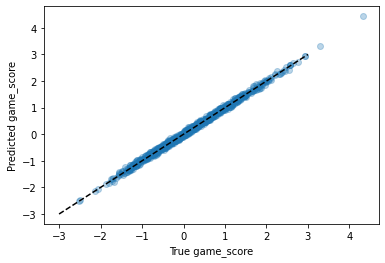

In [8]:
ls = standarize(lebron)

X_lebron = ls[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_lebron = ls["game_score"]

X_train_l, X_test_l, X_cross_l = split_df(X_lebron)
y_train_l, y_test_l, y_cross_l = split_df(y_lebron)

regr_lebron = linear_model.LinearRegression()
regr_lebron.fit(X_train_l, y_train_l) 

print('\nCoefs (per dim) ', regr_lebron.coef_, ' and intercept: ', regr_lebron.intercept_)
print('\nTraining Score:', regr_lebron.score(X_train_l, y_train_l) )
print('Testing Score:', regr_lebron.score(X_test_l, y_test_l) )
print('\nTraining MSE: ', np.mean((regr_lebron.predict(X_train_l) - y_train_l)**2))
print('Testing MSE: ', np.mean((regr_lebron.predict(X_test_l) - y_test_l)**2))
print('\nTesting R2 score: ', r2_score(y_test_j, regr_jordan.predict(X_test_j)))

#Visualization of target and predicted responses
clf = linear_model.LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)
plt.scatter(y_cross_j, predicted, alpha=0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')